# Statistics and Machine Learning

Some operations are specific to stats people

- `get_dummies`
- `from_dummies` ([someday](https://github.com/pydata/pandas/issues/8745)?)
- `factorize`
- `sample`
- ...

Note: not talking about your `mean`s and `std`s here.

It's quite common to have categorical data (in the statistical sense), which must be transformed before putting them into an algorithm. There are a couple ways to handle this.

### Factorization

This basically creates a mapping between the categories and integers. This sometimes makes sense if you're representing soemthing like responses to a survey where the responses are `bad`, `neutral` and `good`.

In [213]:
s = pd.Series(pd.Categorical(np.random.choice(['bad', 'neutral', 'good'], size=40),
                             categories=['bad', 'neutral', 'good'], ordered=True))
s

0        good
1        good
2     neutral
3        good
4        good
       ...   
35        bad
36       good
37        bad
38        bad
39        bad
dtype: category
Categories (3, object): [bad, neutral, good]

In [215]:
s.cat.codes

0     2
1     2
2     1
3     2
4     2
     ..
35    0
36    2
37    0
38    0
39    0
dtype: int8

This can potentially be misleading. If you feed it into something like OLS it implies that the "distance" between `bad` and `neutral` is the same as between `neutral` and `good`.

In [216]:
from sklearn import datasets

In [234]:
iris['feature_names']

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [237]:
iris = datasets.load_iris()

X = iris['data']
y = iris['target']
feature_names = iris['feature_names']
target_names = iris['target_names']


In [240]:
pd.DataFrame(X, columns=feature_namesdd)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [171]:
import statsmodels.api as sm

# Integration with other libraries

The two foundational libraries for stats in python are statsmodels and scikit-learn.
Everyone speaks *lingua franca* of NumPy arrays, but there is some integration at the higher level of DataFrames.

# Statsmodels

Brief primer: you give a **estimator** (OLS, WLS, GLM) a **formula** and **dataset**. You then fit that model. The integration with pandas here is fantastic.

http://nbviewer.ipython.org/urls/umich.box.com/shared/static/zyl08wsmxwoh6ts70v4o.ipynb?


In [125]:
import statsmodels.api as sm
%matplotlib inline
pd.options.display.max_rows = 10

We've got some longintudinal data (repeated measures of the same individual on children with HIV. There are two treatment arms, and each child receives an anti-retroviral theropy or are  in the control. Here's the data:

In [138]:
df = pd.read_csv('data/cd4.csv', parse_dates=['VDATE'], index_col=['newpid', 'VISIT'])
df = df.dropna()  # estimator can't handle NaNs so ignore for now.
df.head()

VDATE  CD4PCT  arv    visage  treatmnt  CD4CNT  baseage
newpid VISIT                                                             
1      1     1988-06-29      18    0  3.910000         1     323     3.91
       4     1989-01-19      37    0  4.468333         1     610     3.91
       7     1989-04-13      13    0  4.698333         1     324     3.91
       13    1989-11-30      13    0  5.330833         1     626     3.91
       19    1990-06-07      12    1  5.848333         1     220     3.91

Some basic statistics:

In [139]:
df.assign(cnt=1).groupby(['arv', 'treatmnt']).cnt.sum().unstack()

treatmnt,1,2
arv,,
0,486,402
1,48,42


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 978 entries, (1, 1) to (254, 7)
Data columns (total 7 columns):
VDATE       978 non-null datetime64[ns]
CD4PCT      978 non-null float64
arv         978 non-null float64
visage      978 non-null float64
treatmnt    978 non-null int64
CD4CNT      978 non-null float64
baseage     978 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 58.5+ KB


In [141]:
df.groupby('arv').CD4CNT.mean()

arv
0    947.930180
1    926.166667
Name: CD4CNT, dtype: float64

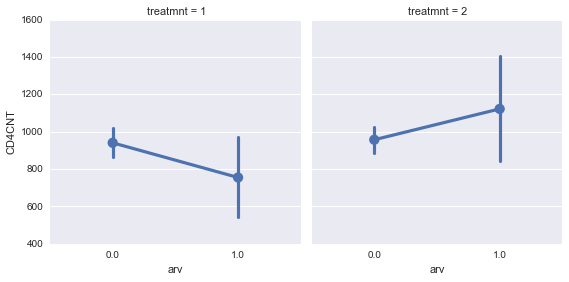

In [144]:
sns.factorplot(x='arv', y='CD4CNT', col='treatmnt', data=df)

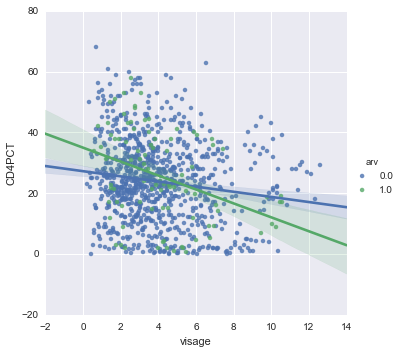

In [147]:
sns.lmplot("visage", "CD4PCT", data=df, hue="arv")

These statistics are throwing away alot of informatin. They don't tie one observation of an individual to the second observatino *of the same individual*. We'd expect some people to consistently have higher or lower `CD4PCT` than others. We'll use a GEE model, but we have to extract the age at the time of each observation to get there.

In [160]:
# apply instead of transform becasue of dtypes.
years_since = df.groupby(level='newpid').VDATE.apply(lambda x: (x - x.min()).dt.days / 365)
df['age'] = df.baseage + years_since

In [161]:
df.head()

VDATE  CD4PCT  arv    visage  treatmnt  CD4CNT  baseage  \
newpid VISIT                                                                
1      1     1988-06-29      18    0  3.910000         1     323     3.91   
       4     1989-01-19      37    0  4.468333         1     610     3.91   
       7     1989-04-13      13    0  4.698333         1     324     3.91   
       13    1989-11-30      13    0  5.330833         1     626     3.91   
       19    1990-06-07      12    1  5.848333         1     220     3.91   

                   age  
newpid VISIT            
1      1      3.910000  
       4      4.468904  
       7      4.699041  
       13     5.331918  
       19     5.849726

In [165]:
mod_basic = sm.GEE.from_formula("CD4PCT ~ age + arv + treatmnt", "newpid", df.reset_index())
res_basic = mod_basic.fit()
res_basic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      CD4PCT   No. Observations:                  978
Model:                                 GEE   No. clusters:                      226
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   7
Family:                           Gaussian   Mean cluster size:                 4.3
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Thu, 25 Jun 2015   Scale:                         171.820
Covariance type:                    robust   Time:                         22:51:34
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     23.9086      2.997      7.977      0.000        18.034    29.783
age           -0.9923      0.373     -2.661      0.008        -1.723    -0.261
arv            1.6919      2.070      0.817      0.414        -2.365     5.749
treatmnt       2.7020      1.635      1.653      0.098        -0.503     5.907
==============================================================================
Skew:                          0.2773   Kurtosis:                      -0.3432
Centered skew:                 0.2924   Centered kurtosis:              3.2945
==============================================================================
"""

In [166]:
ex = sm.cov_struct.Exchangeable()
mod_exchangable = sm.GEE.from_formula("CD4PCT ~ age + arv + treatmnt", "newpid", df.reset_index(),
                                      cov_struct=ex)
res_exchangable = mod_exchangable.fit()
res_exchangable.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      CD4PCT   No. Observations:                  978
Model:                                 GEE   No. clusters:                      226
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   7
Family:                           Gaussian   Mean cluster size:                 4.3
Dependence structure:         Exchangeable   Num. iterations:                    10
Date:                     Thu, 25 Jun 2015   Scale:                         175.419
Covariance type:                    robust   Time:                         22:52:10
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     27.4284      2.801      9.792      0.000        21.939    32.918
age           -1.7609      0.336     -5.244      0.000        -2.419    -1.103
arv            1.9451      1.181      1.647      0.100        -0.369     4.260
treatmnt       1.9567      1.569      1.247      0.212        -1.119     5.032
==============================================================================
Skew:                          0.2521   Kurtosis:                      -0.3788
Centered skew:                 0.2914   Centered kurtosis:              3.3861
==============================================================================
"""

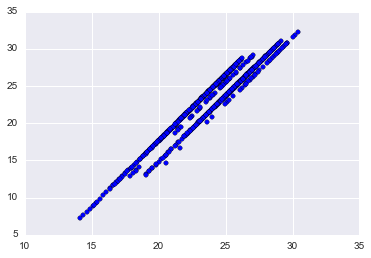

In [168]:
plt.scatter(res_basic.fittedvalues, res_exchangable.fittedvalues)

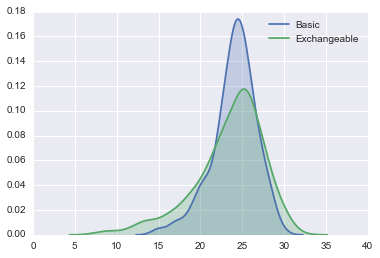

In [170]:
sns.kdeplot(res_basic.fittedvalues, shade=True, label='Basic')
sns.kdeplot(res_exchangable.fittedvalues, shade=True, label='Exchangeable')

In [148]:
# aside: MultiIndex slicers if we don't get there elsewhere.
# df.loc[(slice(None), 1), 'first_visit_date'] = df.loc[(slice(None), 1), :].VDATE
# df.head()

# Scikit-learn

An awesome library. It deals with NumPy arrays (and DataFrames to an extent).